In [1]:
#import required libraries
from numpy import loadtxt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as pl
from scipy.stats import skew
from scipy.optimize import least_squares
from scipy.io import savemat
from scipy import stats
import scipy.stats
import matplotlib.patches as patches
import util_mod
import datetime as dt
import pandas as pd
import natsort
import csv
from osgeo import gdal, osr, ogr

In [2]:
#These are a bunch of variables that we have to define for the cells below. We will change these parameters for each InSAR dataset that we use
sbas_list='sbas_list_reduced'#list of SBAS Interferogram pairs with scene names, temporal baseline, and spatial baseline
intlist='intlist_reduced'#list of interferograms corresponding to SBAS list
geolist='geolist_reduced'#list of scene names
nr0, nr =2214, 2214 #number of pixels in range
naz0, naz =3600, 3600 #number of pixels in azimuth
Bperp_file='Bperp_reduced.out' #matrix of (spatial) perpendicular baseline values
Tm_file='Tm_reduced.out' #matrix of temporal baseline values
deltime_file='deltime_reduced.out' #matrix of delta time values
timedeltas_file='timedeltas_reduced.out'
wvl=0.0554 #wavelength of radar (C band for Sentinel)
skew_val=0.4 #Skewness value for thresholding good and bad data

###highest average coherence through stack###
r_ref=[108, 154, 124, 101, 137]   #  reference pixel location
az_ref=[1111, 1271, 1117, 1319, 1244]  #  reference pixel location

In [3]:
#Step 1.
#1a. Read in all InSAR data (.unw unwrapped interferograms, .cc coherence files)
#1b. Read in ancillary files (list files, SBAS matrices)

print('Reading in InSAR data and SBAS Ancillary files')
f = open(sbas_list,'r')
sbas_pairs = []
for line in f:
    sbas_pairs.append(line.strip()) #.strip() function removes both the leading and the trailing characters
f.close()

f = open(intlist,'r')
int_pairs = []
for line in f:
    int_pairs.append(line.strip()) # reading in the data files so that the program can understand the data
f.close()                          #similar to when we truncated data previously 

f = open(geolist,'r')
geos = []
for line in f:
    geos.append(line.strip())
f.close()
N_geo = len(geos)
print('done')

Reading in InSAR data and SBAS Ancillary files
done


In [4]:
#Read in Bperp info
lines = []
with open(Bperp_file, 'r') as fileobj:
    for row in fileobj:
        line = row.rstrip('\n')
        lines.append(float(line))
Bperp = np.asarray(lines)
N_int = Bperp.size

print('done')

done


In [5]:
#Read in time information
count1 = []
dtime_ints1 = []
time11 = []
time21 = []
with open(deltime_file, 'r') as fileobj:  #108 rows
    for row in fileobj:
        line = row.rstrip('\n')
        line_vals = line.split(' ')
        count1.append(float(line_vals[0]))
        dtime_ints1.append(float(line_vals[1]))
        time11.append(float(line_vals[2]))
        time21.append(float(line_vals[3]))
count = np.asarray(count1)
dtime_ints = np.asarray(dtime_ints1)
time1 = np.asarray(time11)
time2 = np.asarray(time21)
dtime_scenes_list = []
with open(timedeltas_file, 'r') as fileobj:  #113 rows
    for row in fileobj:
        line = row.rstrip('\n')
        dtime_scenes_list.append(float(line))
dtime_scenes = np.asarray(dtime_scenes_list)
N_scene = dtime_scenes.size+1
geo_dates = []
geo_doys = []
#geo_years=[] #
#geo_days=[]  #
#geo_months=[]#
for (i,geo) in enumerate(geos):
	d1 = geo[20:28]
	year1 = d1[0:4]
	month1 = d1[4:6]
	day1 = d1[6:8]
	doy1 = (dt.date(int(year1), int(month1), int(day1)) - dt.date(int(year1),1,1)).days + 1
	geo_dates.append(str(day1))
	geo_doys.append(int(doy1))

In [6]:
#Read in Tm matrix as array N_int by N_scene
Tm1 = []
with open(Tm_file, 'r') as fileobj:
    for row in fileobj:
        line_vals = row.rstrip('\n')
        #line_vals=line.split(' ')
        #Tm1.append(line_vals[0:(N_scene-1)])
        Tm1.append(line_vals)
Tm0 = np.asarray(Tm1)
Tm2 = np.zeros((N_int,N_scene-1))
for i in range(N_int):
	line = Tm0[i]
	line_vals = line.split(' ')
	for j in range(N_scene-1):
		Tm2[i,j] = float(line_vals[j])
Tm = np.copy(Tm2)

In [7]:
#filtering .int files

good_scen2 = [1,2,3,4,10,11,12,13,14,15,16,17,18,19,20,28,30,32,33,
             34,35,36,37,38,42,57,59,60,61,62,66,67,69,75,79,80,81,
             82,83,84,85,86,87,88,89,90,91,92,93,94,98,100,102,103,
             105,106,108,109,110,112,115,125,126,127,129,130,132,133,
             134,135,136,137,138,139,140,141,142,145,148,150,151,153,
             154,157,160,162,163,164,165,166,167,168,169,170,171,172,
             175,181,184,190,193,195,196,197,198,199,200,201]

int_pairs = pd.DataFrame(int_pairs)

int_pairs.columns = ['.int date']

int_pairs = int_pairs['.int date']

int_pairs_filt = int_pairs.iloc[good_scen2]

int_pairs_filt = list(int_pairs_filt)

In [8]:
#Read in interferograms, unwrapped interferograms, coherence, and amplitude files
unw_phase = np.zeros((2100,1350,int(N_int)))
coh = np.zeros((2100,1350,int(N_int)))
date_pairs = []
doy_pairs = []

for (i,int_pair) in enumerate(int_pairs_filt):
    print(i)
    strunw1 = int_pair.replace('.int','.unw')
    stramp1 = int_pair.replace('.int','.amp')
    strcc1 = int_pair.replace('.int','.cc')
    strint1 = int_pair

    strunw = 'unws/'+str(strunw1)
    strint = 'ints/'+str(strint1)
    stramp = 'amps/'+str(stramp1)
    strcc = 'ccs/'+str(strcc1)

    (amp,unw) = util_mod.read_hgt_file(strunw,nr0)
    (amp,cor) = util_mod.read_hgt_file(strcc,nr0)

    unw_phase[:,:,i] = unw[500:2600,650:2000]
    coh[:,:,i] = cor[500:2600,650:2000]

    split1 = int_pair.split('_')
    d1 = split1[0]
    strint2 = split1[1]
    split2 = strint2.split('.')
    d2 = split2[0]

    year1 = d1[0:4]
    month1 = d1[4:6]
    day1 = d1[6:8]
    year2 = d2[0:4]
    month2 = d2[4:6]
    day2 = d2[6:8]

    doy1 = (dt.date(int(year1), int(month1), int(day1)) - dt.date(int(year1),1,1)).days + 1
    doy2 = (dt.date(int(year2), int(month2), int(day2)) - dt.date(int(year2),1,1)).days + 1

    date_pair = [d1,d2]
    doy_pair = [doy1,doy2]
    date_pairs.append(date_pair)
    doy_pairs.append(doy_pair)

print('Calculating Scenewide Average Coherence')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
Calculating Scenewide Average Coherence


In [9]:
avecc = np.mean(coh,axis=2)
cor_mask = np.copy(avecc)
cor_mask[cor_mask<0.425]=np.nan
cor_mask[cor_mask>0.425]=1
phase_cal = np.copy(unw_phase)

In [10]:
def sbas(dtime_scenes, array, Tm_good, naz_min, naz_max, nr_min, nr_max):
    '''
    Function to implement SBAS processing method according to
    specified subsets.
    '''    
    #reference pixel location
    r_ref=[108, 124, 124, 137, 154]  
    az_ref=[1111, 1117, 1118, 1244, 1271]
    
    #define range of subsetted image
    naz,nr = naz_max-naz_min, nr_max-nr_min
    print('Calibrating Phase with '+str(len(r_ref))+' reference pixels')
    print('Range coordinates of reference pixels are '+str(r_ref))
    print('Azimuth coordinates of reference pixels are '+str(az_ref))
    
    #incorporate reference points for processing
    pluck=array[az_ref,r_ref,:]
    pluck1=np.mean(pluck,axis=0)
    refphase=pluck1
    
    #inversion
    Tmi=np.linalg.pinv(Tm_good) 
    
    siz=Tmi.shape
    N_good=siz[0]
    velocities=np.zeros((naz,nr,N_good))

    print('Inverting for Instantaneous Phase Velocities')
    
    for i in range(naz_min,naz_max):
        for j in range(nr_min,nr_max):
            pluck = np.squeeze(array[i,j,:]) - np.squeeze(refphase)
            sol=np.matmul(Tmi,pluck)
            velocities[i-naz_min,j-nr_min,:] = sol
     
    phi_vec = np.zeros((naz,nr,len(geo_doys)))
    
    print('Integrating Phase Velocities into Time Series of Displacement')
    for i in range(naz):
        for j in range(nr):
            phi=np.zeros((N_scene,1))
            for k in range(2,N_geo):
                phi[k] = phi[k-1] + dtime_scenes[k-1]*velocities[i,j,k-1]
                
            phi_vec[i,j,:] = np.squeeze(phi)
    
    #converting radians to meters
    time_series132 = phi_vec *(-wvl/(4*np.pi)) 
    
    return time_series132

In [11]:
#Northwest sbas applied
#more scenes than interferograms NEED TO FIX
series_good_nw2 = sbas(dtime_scenes, phase_cal, Tm, 0, 1050, 0, 675)

Calibrating Phase with 5 reference pixels
Range coordinates of reference pixels are [108, 124, 124, 137, 154]
Azimuth coordinates of reference pixels are [1111, 1117, 1118, 1244, 1271]
Inverting for Instantaneous Phase Velocities
Integrating Phase Velocities into Time Series of Displacement


In [12]:
#Northeast sbas applied
series_good_ne2 = sbas(dtime_scenes, phase_cal, Tm, 0, 1050, 675, 1350)

Calibrating Phase with 5 reference pixels
Range coordinates of reference pixels are [108, 124, 124, 137, 154]
Azimuth coordinates of reference pixels are [1111, 1117, 1118, 1244, 1271]
Inverting for Instantaneous Phase Velocities
Integrating Phase Velocities into Time Series of Displacement


In [13]:
#Southeast sbas applied
series_good_se2 = sbas(dtime_scenes, phase_cal, Tm, 1050, 2100, 675, 1350)

Calibrating Phase with 5 reference pixels
Range coordinates of reference pixels are [108, 124, 124, 137, 154]
Azimuth coordinates of reference pixels are [1111, 1117, 1118, 1244, 1271]
Inverting for Instantaneous Phase Velocities
Integrating Phase Velocities into Time Series of Displacement


In [14]:
#Southwest sbas applied
series_good_sw2 = sbas(dtime_scenes, phase_cal, Tm, 1050, 2100, 0, 675)

Calibrating Phase with 5 reference pixels
Range coordinates of reference pixels are [108, 124, 124, 137, 154]
Azimuth coordinates of reference pixels are [1111, 1117, 1118, 1244, 1271]
Inverting for Instantaneous Phase Velocities
Integrating Phase Velocities into Time Series of Displacement


In [15]:
series_good_nw_ne2 = np.concatenate((series_good_nw2, series_good_ne2),axis=1)
series_good_sw_se2 = np.concatenate((series_good_sw2, series_good_se2),axis=1)
series_good_tot2 = np.concatenate((series_good_nw_ne2,series_good_sw_se2),axis=0)

In [ ]:
#HERE need to save output matrices

In [16]:
#numpy.savetxt('series_good_tot2.csv', series_good_tot2, delimiter=',')

In [84]:
def mean(title,array,y,x):
    '''Calculate the average of clustered pixels, calculate statistical 
    values, calculate the rate of ice aggradation, visualize results'''
    #populate list with 9 different arrays
    arr = [array[y,x,0:77],array[y+7,x,0:77],array[y-7,x,0:77],array[y,x+7,0:77],array[y,x-7,0:77],
          array[y+7,x+7,0:77],array[y-7,x+7,0:77],array[y-7,x-7,0:77],array[y+7,x-7,0:77]]
    arr = np.array(arr)*100
    t_days = np.cumsum(dtime_scenes)
    t_days = t_days[0:77]
    #convert to numpy array for processing
    rolling_avg = np.mean(arr, axis = 0)
    std_dev = np.std(arr, axis = 0)
    
    #perform least squares inversion on rolling_avg 
    def fractional_polynomial(params, x):
        a, b = params
        return a + b * np.power(x, 0.5)
    # Define the residual function
    def residual(params, x, y):
        return fractional_polynomial(params, x) - y
    # Initial guess for the parameters
    initial_params = np.array([1, 1])
    # Fit the data using least squares optimization
    result = least_squares(residual, initial_params, args=(t_days, rolling_avg))
    # Extract the optimized parameters
    optimized_params = result.x
    # array we want
    frac = fractional_polynomial(optimized_params, t_days)
    #calculate R^2 value
    ss_residual = np.sum((rolling_avg - frac) ** 2)
    ss_total = np.sum((rolling_avg - np.mean(rolling_avg)) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    #calculate p-value
    n = len(rolling_avg)
    k = len(optimized_params)
    dof = n - k - 1
    ssr = ss_residual
    mse = ssr / dof
    f_value = (ss_total - ss_residual) / k / mse
    p_value = 1 - stats.f.cdf(f_value, k, dof)
    #calculate RMSE 
    rmse = np.sqrt(np.mean((rolling_avg - frac) ** 2))
    
    #rate of ice aggradation
    rate = (frac[-1] - frac[0]) / (t_days[-1] - t_days[0])
    #print(frac[-5],frac[0])
    rate_yr = rate * 365
    rate_tot = rate * 365 *5 #returning cm/5year period 
    print('The total rate of ice aggradation from 2016-2021 is', rate_tot, 'cm/5 years')
    print('The annual rate of ice aggradation from 2016-2021 is', rate_yr, ' cm/year')
    print('The daily rate of ice aggradation from 2016-2021 is', rate, 'cm/day')

    #print inverted paramters
    print("Optimized parameters:")
    print("a =", optimized_params[0])
    print("b =", optimized_params[1])
    #print statistical values
    print("Statistical Values:")
    print("R^2 =", r_squared)
    print("p value =", p_value)
    print("RMSE:", rmse/100)      
    
    plt.figure(figsize = (10,5))
    plt.title(title, fontsize = 14)
    plt.xlabel('Time (Days since first SAR image)', fontsize = 12)
    plt.ylabel('Change in Surface Height (cm)', fontsize = 12)
    plt.plot(t_days, frac,label='Stefans law of ice aggr. fit line', color = 'blue',ls='--')
    plt.plot(t_days, rolling_avg,label='Mean of Clustered Pixels', color = 'black')
    plt.plot(t_days, rolling_avg - std_dev,label='Std. dev. of avg', color = 'red',ls='--')
    plt.plot(t_days, rolling_avg + std_dev,color = 'red',ls='--')
    plt.grid(True)
    plt.legend()
    plt.show()

The total rate of ice aggradation from 2016-2021 is 5.543688153409142 cm/5 years
The annual rate of ice aggradation from 2016-2021 is 1.1087376306818284  cm/year
The daily rate of ice aggradation from 2016-2021 is 0.0030376373443337765 cm/day
Optimized parameters:
a = 0.967817747378186
b = 0.13393190731033294
Statistical Values:
R^2 = 0.6216055983468529
p value = 2.220446049250313e-16
RMSE: 0.01004932372395354


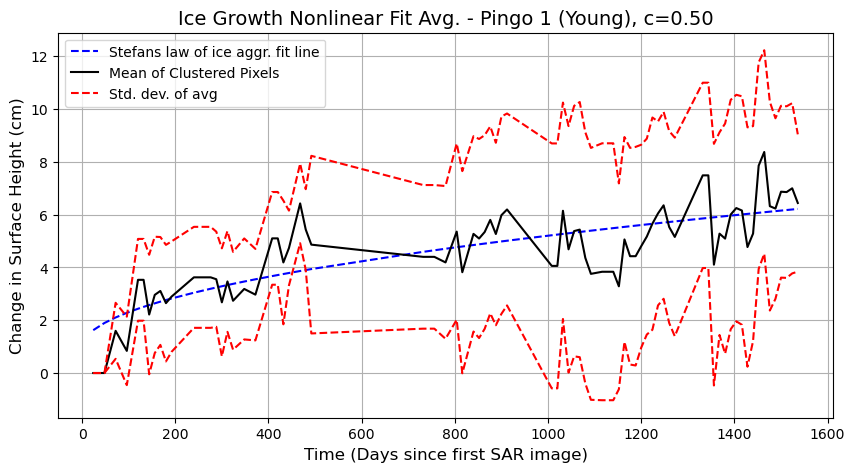

In [86]:
mean('Ice Growth Nonlinear Fit Avg. - Pingo 1 (Young), c=0.50', series_good_tot2,152,1161)

The total rate of ice aggradation from 2016-2021 is 9.237400964533125 cm/5 years
The annual rate of ice aggradation from 2016-2021 is 1.847480192906625  cm/year
The daily rate of ice aggradation from 2016-2021 is 0.005061589569607191 cm/day
Optimized parameters:
a = 0.5375391136361508
b = 0.2231696111927605
Statistical Values:
R^2 = 0.8358006726006116
p value = 1.1102230246251565e-16
RMSE: 0.009512776121762663


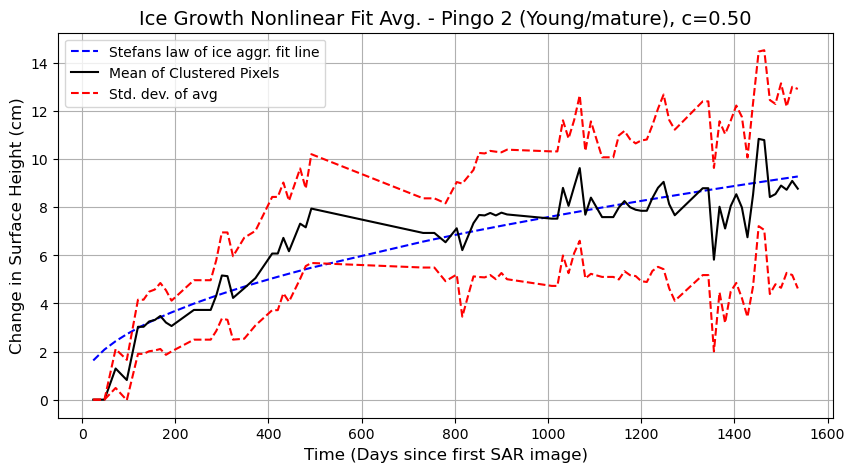

In [87]:
mean('Ice Growth Nonlinear Fit Avg. - Pingo 2 (Young/mature), c=0.50', series_good_tot2,310,792)

The total rate of ice aggradation from 2016-2021 is 10.898549643531423 cm/5 years
The annual rate of ice aggradation from 2016-2021 is 2.1797099287062847  cm/year
The daily rate of ice aggradation from 2016-2021 is 0.005971808023852834 cm/day
Optimized parameters:
a = -0.8195925062240867
b = 0.2633018850053604
Statistical Values:
R^2 = 0.901364652750118
p value = 1.1102230246251565e-16
RMSE: 0.008376409217355446


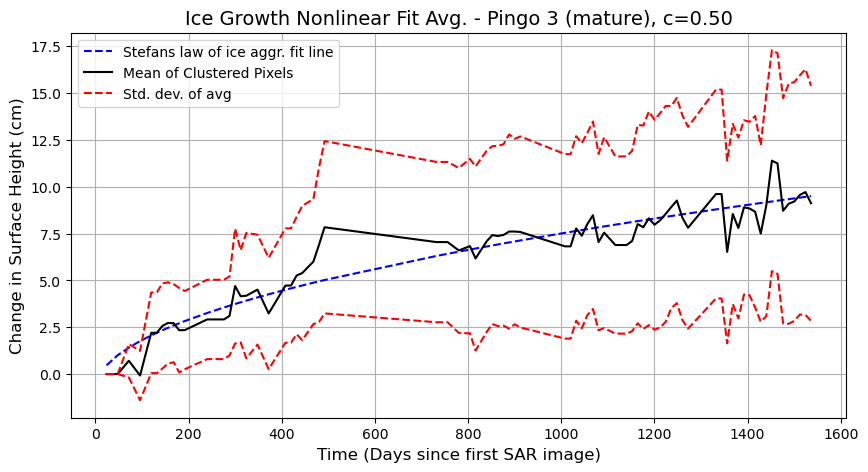

In [88]:
mean('Ice Growth Nonlinear Fit Avg. - Pingo 3 (mature), c=0.50', series_good_tot2,323,830)

The total rate of ice aggradation from 2016-2021 is 4.727728942100959 cm/5 years
The annual rate of ice aggradation from 2016-2021 is 0.9455457884201918  cm/year
The daily rate of ice aggradation from 2016-2021 is 0.0025905364066306624 cm/day
Optimized parameters:
a = 0.19697429948633072
b = 0.11421886241426761
Statistical Values:
R^2 = 0.6803333775130165
p value = 1.1102230246251565e-16
RMSE: 0.007529453886393402


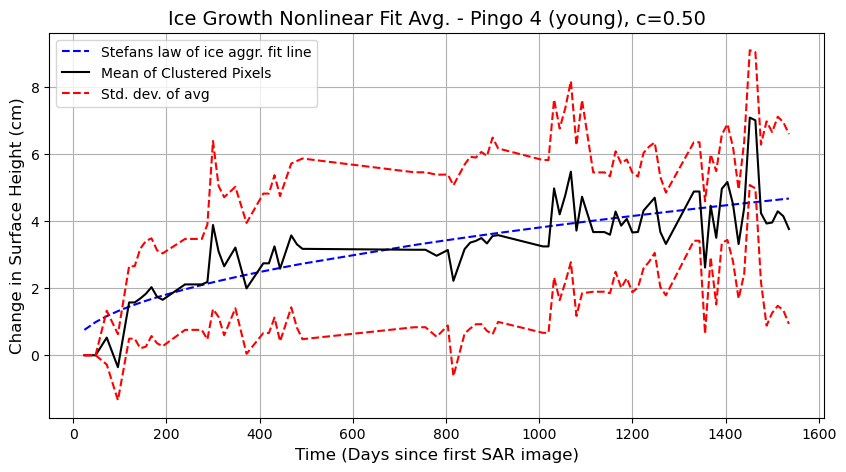

In [89]:
mean('Ice Growth Nonlinear Fit Avg. - Pingo 4 (young), c=0.50', series_good_tot2,331,674)

The total rate of ice aggradation from 2016-2021 is 1.171513155794255 cm/5 years
The annual rate of ice aggradation from 2016-2021 is 0.234302631158851  cm/year
The daily rate of ice aggradation from 2016-2021 is 0.0006419250168735644 cm/day
Optimized parameters:
a = 0.4152301040668307
b = 0.028302997400418865
Statistical Values:
R^2 = 0.06741826709358767
p value = 0.07558149228578537
RMSE: 0.01012336701018569


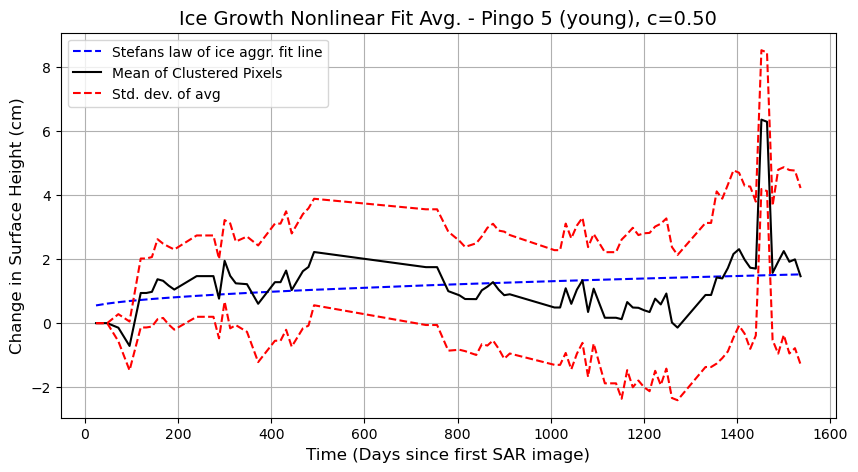

In [90]:
mean('Ice Growth Nonlinear Fit Avg. - Pingo 5 (young), c=0.50', series_good_tot2,694,413)

The total rate of ice aggradation from 2016-2021 is 2.079359729037389 cm/5 years
The annual rate of ice aggradation from 2016-2021 is 0.41587194580747777  cm/year
The daily rate of ice aggradation from 2016-2021 is 0.0011393751939930898 cm/day
Optimized parameters:
a = 0.18844652555742816
b = 0.050235981315618
Statistical Values:
R^2 = 0.19388742912380252
p value = 0.0003440651376951376
RMSE: 0.009850897527978823


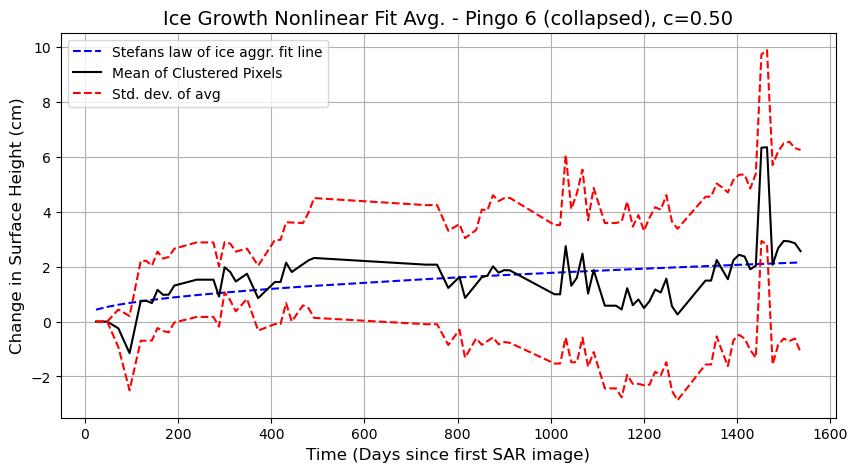

In [91]:
mean('Ice Growth Nonlinear Fit Avg. - Pingo 6 (collapsed), c=0.50', series_good_tot2,727,831)

The total rate of ice aggradation from 2016-2021 is 10.179803441935212 cm/5 years
The annual rate of ice aggradation from 2016-2021 is 2.0359606883870423  cm/year
The daily rate of ice aggradation from 2016-2021 is 0.005577974488731623 cm/day
Optimized parameters:
a = -1.7540364785769842
b = 0.24593744332177842
Statistical Values:
R^2 = 0.7864925322637146
p value = 1.1102230246251565e-16
RMSE: 0.01232315121413939


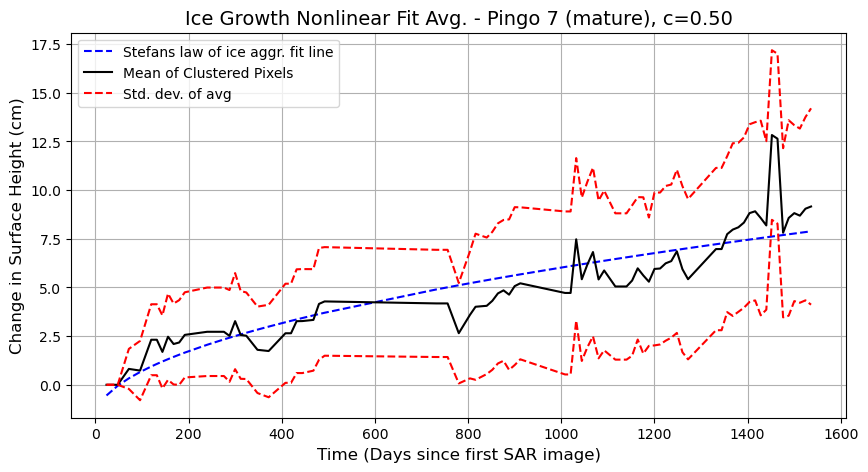

In [92]:
mean('Ice Growth Nonlinear Fit Avg. - Pingo 7 (mature), c=0.50', series_good_tot2,770,790)

The total rate of ice aggradation from 2016-2021 is 7.148414774675416 cm/5 years
The annual rate of ice aggradation from 2016-2021 is 1.4296829549350831  cm/year
The daily rate of ice aggradation from 2016-2021 is 0.003916939602561871 cm/day
Optimized parameters:
a = -0.9511773727550207
b = 0.1727010608323774
Statistical Values:
R^2 = 0.6848410776640679
p value = 1.1102230246251565e-16
RMSE: 0.011266857409916725


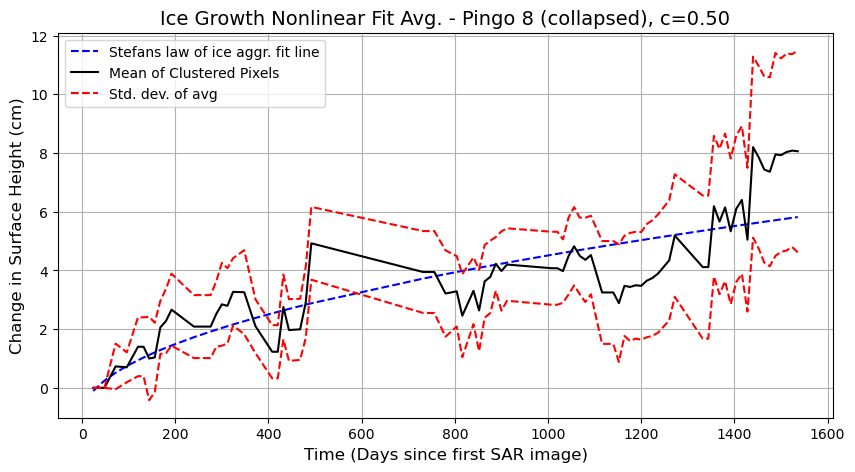

In [93]:
mean('Ice Growth Nonlinear Fit Avg. - Pingo 8 (collapsed), c=0.50', series_good_tot2,1581,674)

The total rate of ice aggradation from 2016-2021 is -3.154197420804005 cm/5 years
The annual rate of ice aggradation from 2016-2021 is -0.6308394841608009  cm/year
The daily rate of ice aggradation from 2016-2021 is -0.001728327353865208 cm/day
Optimized parameters:
a = 1.5088436836532986
b = -0.07620336225835955
Statistical Values:
R^2 = 0.389088137689942
p value = 1.205609467813673e-08
RMSE: 0.009182846211183914


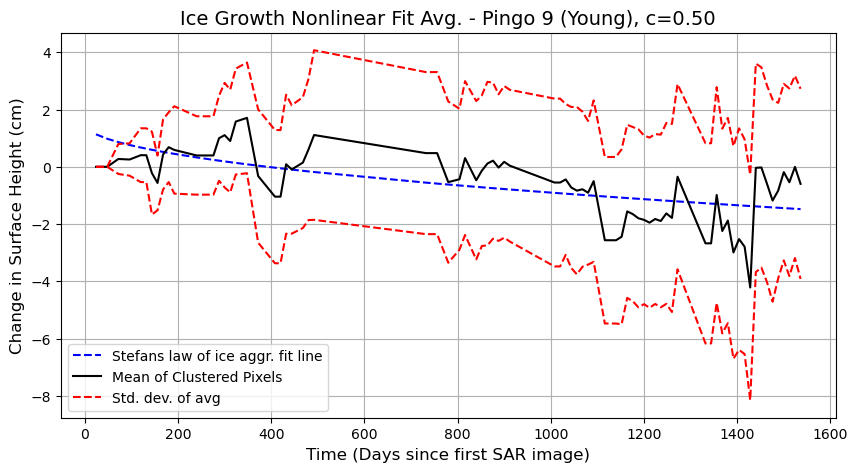

In [94]:
mean('Ice Growth Nonlinear Fit Avg. - Pingo 9 (Young), c=0.50', series_good_tot2,1783,627)

The total rate of ice aggradation from 2016-2021 is 0.15596136850669937 cm/5 years
The annual rate of ice aggradation from 2016-2021 is 0.031192273701339875  cm/year
The daily rate of ice aggradation from 2016-2021 is 8.545828411325993e-05 cm/day
Optimized parameters:
a = 0.5634022940359338
b = 0.0037679254266830544
Statistical Values:
R^2 = 0.0011933541616236942
p value = 0.9567812709048127
RMSE: 0.01048325684316627


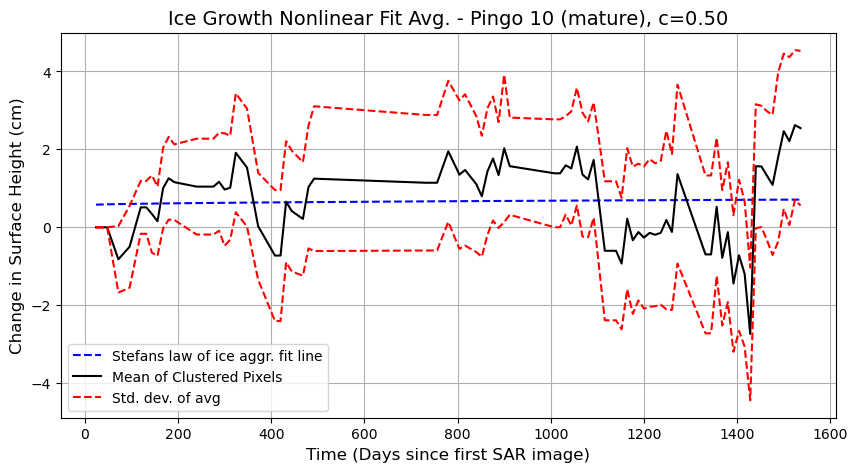

In [95]:
mean('Ice Growth Nonlinear Fit Avg. - Pingo 10 (mature), c=0.50', series_good_tot2,1821,718)

The total rate of ice aggradation from 2016-2021 is -5.367017343039327 cm/5 years
The annual rate of ice aggradation from 2016-2021 is -1.0734034686078655  cm/year
The daily rate of ice aggradation from 2016-2021 is -0.002940831420843467 cm/day
Optimized parameters:
a = 2.5032551492751143
b = -0.12966365521098994
Statistical Values:
R^2 = 0.5009188831225919
p value = 6.797229445965058e-12
RMSE: 0.012446808768471254


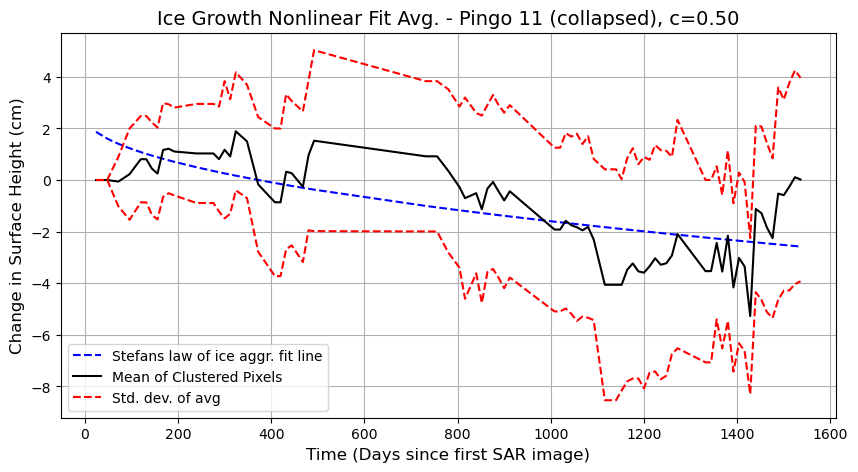

In [96]:
mean('Ice Growth Nonlinear Fit Avg. - Pingo 11 (collapsed), c=0.50', series_good_tot2,1962,659)

The total rate of ice aggradation from 2016-2021 is -3.71131565765864 cm/5 years
The annual rate of ice aggradation from 2016-2021 is -0.742263131531728  cm/year
The daily rate of ice aggradation from 2016-2021 is -0.002033597620634871 cm/day
Optimized parameters:
a = 1.787554964412071
b = -0.08966297722848107
Statistical Values:
R^2 = 0.29803273088698523
p value = 2.0593203725605136e-06
RMSE: 0.013233584507719616


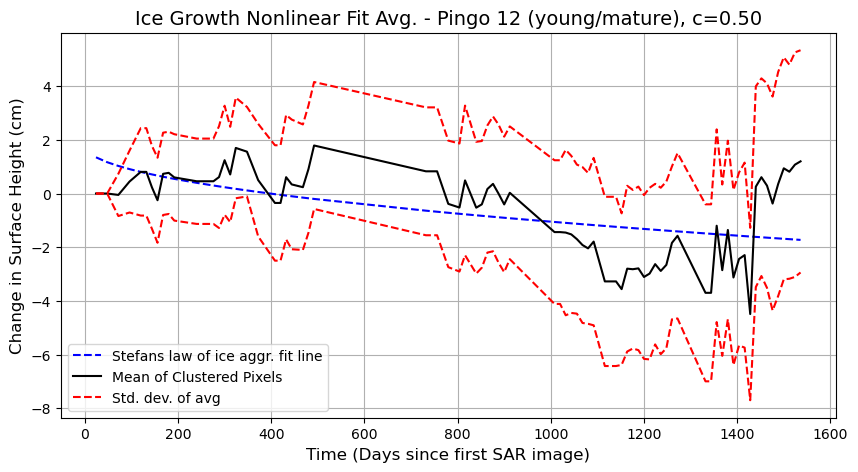

In [97]:
mean('Ice Growth Nonlinear Fit Avg. - Pingo 12 (young/mature), c=0.50', series_good_tot2,2019,571)

In [121]:
#f-test

In [165]:
#2 time-series comparison
def f_test(group1, group2):
    '''Calculate f value between two time series
    and compares results to f critical value 
    with a significance level of 0.05.'''
    #in ftest_scene, group1 will stay constant 
    f = np.var(group1, ddof=1)/np.var(group2, ddof=1)
    nun = x.size-1
    dun = y.size-1
    p_value = 1-scipy.stats.f.cdf(f, nun, dun)
    # F critical value for a significance level of 0.05
    f_crit = scipy.stats.f.ppf(q=1 - .05, dfn=6, dfd=8) 
    #print('f_crit =', f_crit) 
    if f > f_crit:
        #print(f)
        return f
    else: 
        return 0

In [196]:
def compare_to_reference(reference_pixel, data_array):
    '''function to test the variance of
    specified time series to all other time series in 
    the interferograms. Group1 is the input array you
    want to compare all time series to.'''
    result_array = np.zeros(data_array.shape[:-1])  # Create an array to store results
    
    # Iterate through all pixels in the data_array and compare to the reference pixel
    for i in range(data_array.shape[0]):
        for j in range(data_array.shape[1]):
            pixel = data_array[i, j, :]
            result_array[i, j] = f_test(reference_pixel, pixel)
    
    return result_array

In [198]:
array_shape = (2000, 1350, 77)
data_array = series_good_tot2

# Select a reference pixel for comparison
reference_pixel = series_good_tot2[323,830,:]

# Apply the compare_to_reference function to compare the reference pixel to all other pixels
result_array = compare_to_reference(reference_pixel, data_array)
print(result_array.shape)

(2100, 1350)


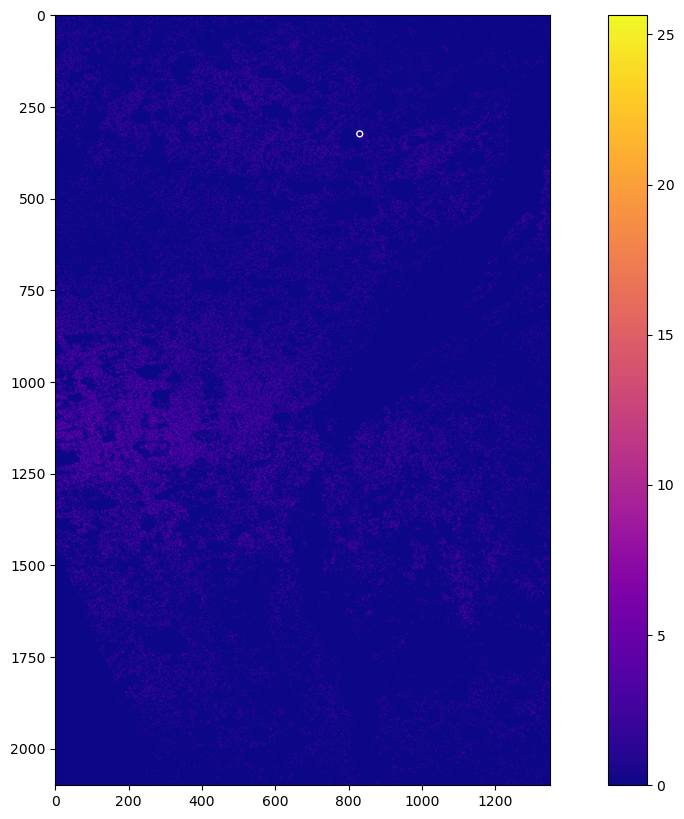

In [200]:
plt.figure(figsize=(15,10))
plt.imshow(result_array,cmap='plasma')
#plt.ylim(310,330)
#plt.xlim(820,840)
c = plt.Circle((830,323),8,fill=0,color='white')
plt.gca().add_artist(c)
plt.colorbar()
plt.show()

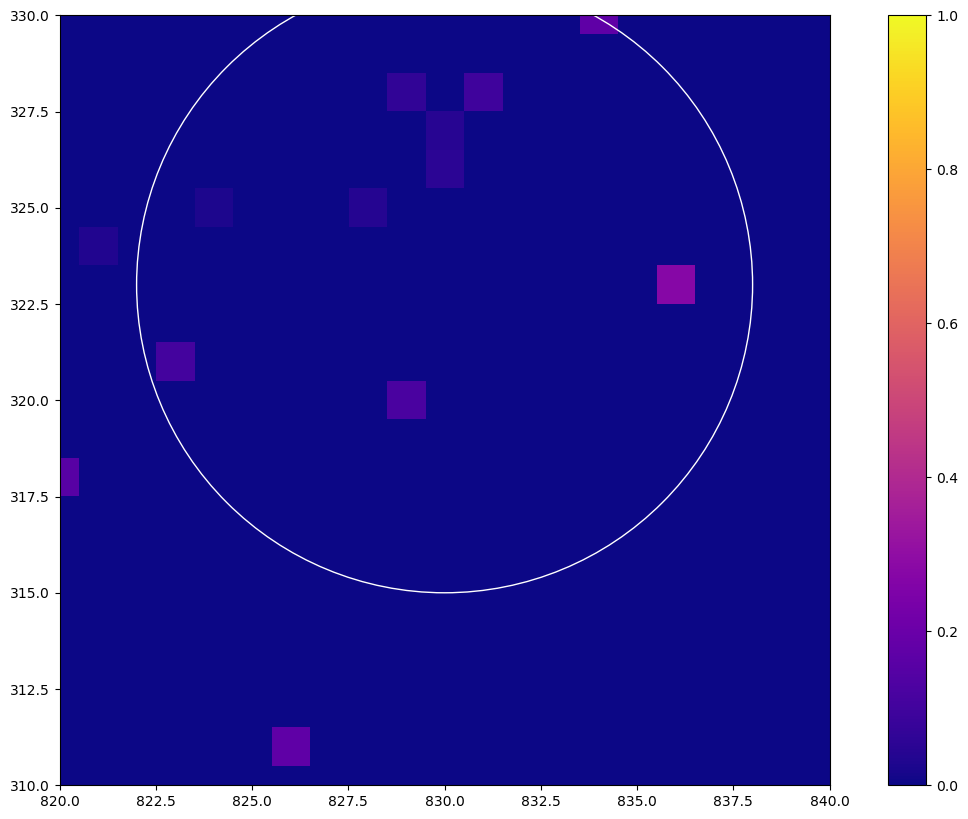

In [262]:
plt.figure(figsize=(15,10))
plt.imshow(result_array,cmap='plasma')
plt.ylim(310,330)
plt.xlim(820,840)
c = plt.Circle((830,323),8,fill=0,color='white')
plt.gca().add_artist(c)
plt.colorbar()
plt.show()

In [169]:
#cross correlation example
from scipy.signal import correlate

In [301]:
#def cross_correlation(reference_pixel, data_array, correlation_threshold):
#    num_rows, num_columns, num_scenes = data_array.shape
#    result_array = np.zeros((num_rows, num_columns))
#    
#    #reference_series = reference_pixel.ravel()  # Flatten the reference pixel's time series
#    
#    for row in range(num_rows):
#        for col in range(num_columns):
#            pixel_series = data_array[row, col, :]  # Extract time series of the current pixel
#            cross_corr = correlate(pixel_series, reference_pixel, mode='valid')
#            
#            max_corr = np.max(cross_corr)
#            if max_corr > correlation_threshold:
#                result_array[row, col] = max_corr
#    
#    return result_array

In [302]:
# Select a reference pixel for comparison
#reference_pixel = series_good_tot2[770,790,:] 

# Set a correlation threshold to determine similarity
#correlation_threshold = 0.5

# Apply the compare_with_cross_correlation function
#result_array = cross_correlation(reference_pixel, data_array, correlation_threshold)
#print(result_array.shape)

In [303]:
# Plotting the heatmap
#plt.figure(figsize=(10, 8))
#c = plt.Circle((790,770),8,fill=0,color='white')
#plt.gca().add_artist(c)
#plt.imshow(result_array, cmap='viridis', aspect='auto')
#plt.colorbar(label='Max Cross-Correlation')
#plt.title('Cross-Correlation Heatmap')
#plt.xlabel('Column Index')
#plt.ylabel('Row Index')
#plt.show()

In [190]:
#Pearson correlation coefficient test#
from scipy.stats import pearsonr

In [300]:
#def compare_with_pearson(reference_pixel, data_array, correlation_threshold):
#    num_rows, num_columns, num_scenes = data_array.shape
#    result_array = np.zeros((num_rows, num_columns))
#    
#    for row in range(num_rows):
#        for col in range(num_columns):
#            pixel_series = data_array[row, col, :]
#            correlation, _ = pearsonr(reference_pixel, pixel_series)
#            
#            if correlation > correlation_threshold:
#                result_array[row, col] = correlation
#    
#    return result_array
#
## Select a reference pixel for comparison
#reference_pixel = series_good_tot2[770, 790, :] 

In [299]:
# Set a correlation threshold to determine similarity
#correlation_threshold = 0.8

In [298]:
# Apply the compare_with_pearson function
#result_array = compare_with_pearson(reference_pixel, data_array, correlation_threshold)

In [ ]:
# Plotting the heatmap
#plt.figure(figsize=(10, 8))
#c = plt.Circle((790,770),8,fill=0,color='white')
#plt.gca().add_artist(c)
#plt.imshow(result_array, cmap='viridis', aspect='auto', vmin=-1, vmax=1)
#plt.colorbar(label='Pearson Correlation')
#plt.title('Pearson Correlation Heatmap')
#plt.xlabel('Column Index')
#plt.ylabel('Row Index')
#plt.show()

In [230]:
#attempting Euclidean distance test
from scipy.spatial.distance import euclidean

In [287]:
def compare_with_euclidean(reference_pixel, data_array, distance_threshold):
    num_rows, num_columns, num_scenes = data_array.shape
    result_array = np.zeros((num_rows, num_columns))
    
    for row in range(num_rows):
        for col in range(num_columns):
            pixel_series = data_array[row, col, :]
            distance = euclidean(reference_pixel, pixel_series)
            
            if distance < distance_threshold:
                result_array[row, col] = 1.0 - (distance / distance_threshold)
    
    return result_array

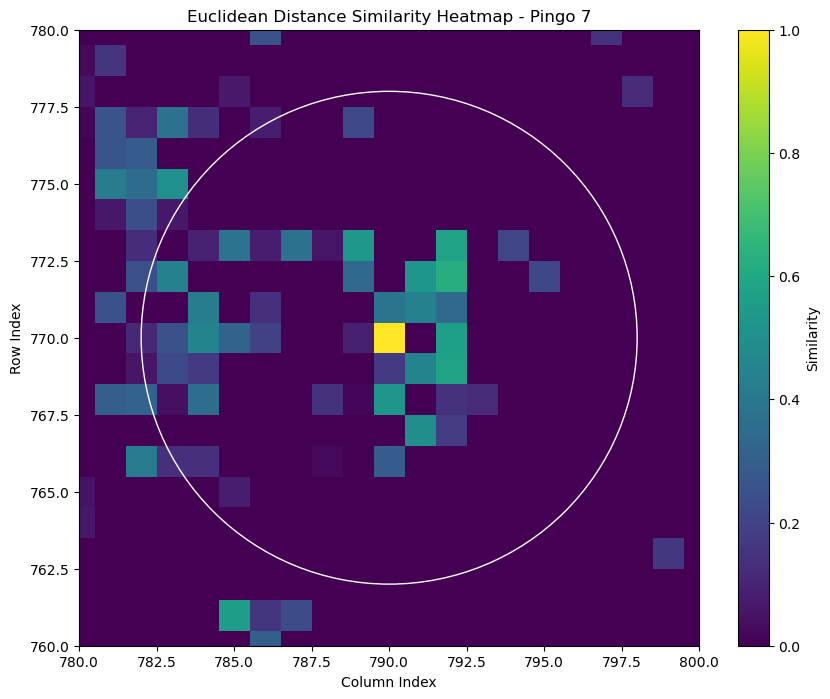

In [324]:
# Assuming you have your array with shape (2000, 1350, 77)
array_shape = (2000, 1350, 77)

# Select a reference pixel for comparison
reference_pixel = series_good_tot2[770,790,:]  # Example reference pixel

# Set a distance threshold to determine similarity
distance_threshold = .3

# Apply the compare_with_euclidean function
result_array = compare_with_euclidean(reference_pixel, data_array, distance_threshold)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
c = plt.Circle((790,770),8,fill=0,color='white')
plt.gca().add_artist(c)
plt.xlim(780,800)
plt.ylim(760,780)
plt.imshow(result_array, cmap='viridis', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='Similarity')
plt.title('Euclidean Distance Similarity Heatmap - Pingo 7')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

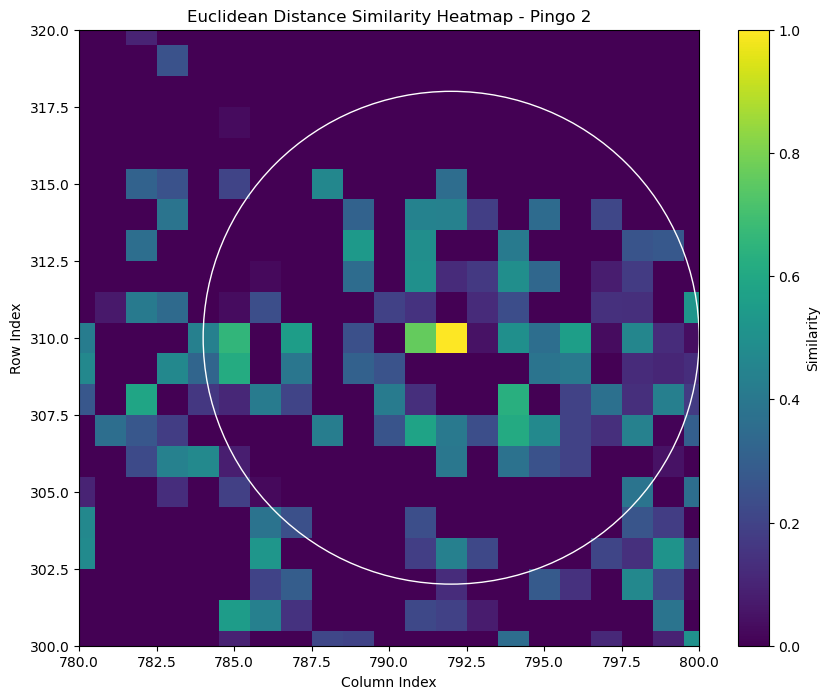

In [322]:
# Select a reference pixel for comparison
reference_pixel = series_good_tot2[310,792,:]  # Example reference pixel

distance_threshold = 0.2

# Apply the compare_with_euclidean function
result_array = compare_with_euclidean(reference_pixel, data_array, distance_threshold)


# Plotting the heatmap
plt.figure(figsize=(10, 8))
c = plt.Circle((792,310),8,fill=0,color='white')
plt.gca().add_artist(c)
plt.xlim(780,800)
plt.ylim(300,320)
plt.imshow(result_array, cmap='viridis', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='Similarity')
plt.title('Euclidean Distance Similarity Heatmap - Pingo 2')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

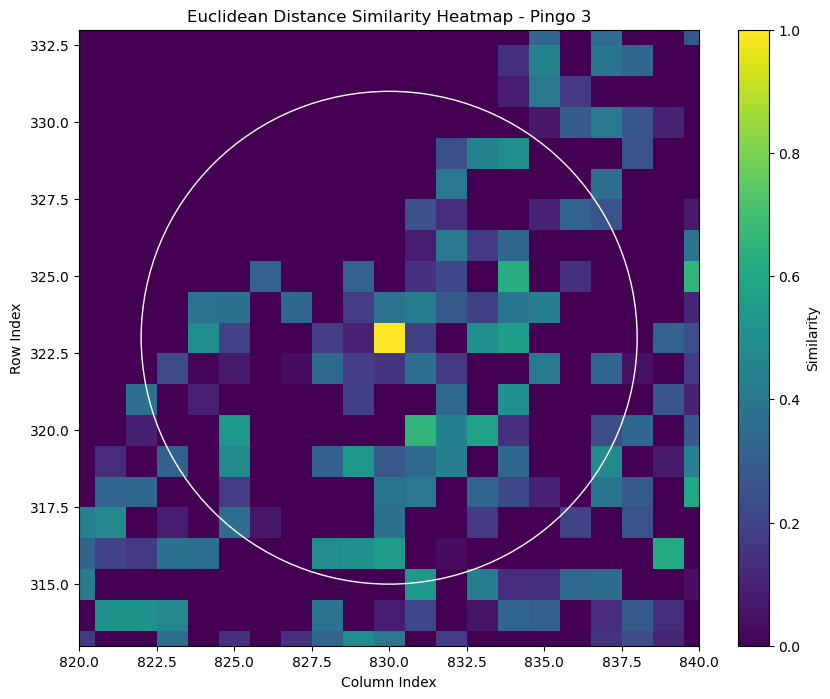

In [321]:
# Select a reference pixel for comparison
reference_pixel = series_good_tot2[323,830,:]  # Example reference pixel

distance_threshold = 0.2

# Apply the compare_with_euclidean function
result_array = compare_with_euclidean(reference_pixel, data_array, distance_threshold)


# Plotting the heatmap
plt.figure(figsize=(10, 8))
c = plt.Circle((830,323),8,fill=0,color='white')
plt.gca().add_artist(c)
plt.xlim(820,840)
plt.ylim(313,333)
plt.imshow(result_array, cmap='viridis', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='Similarity')
plt.title('Euclidean Distance Similarity Heatmap - Pingo 3')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

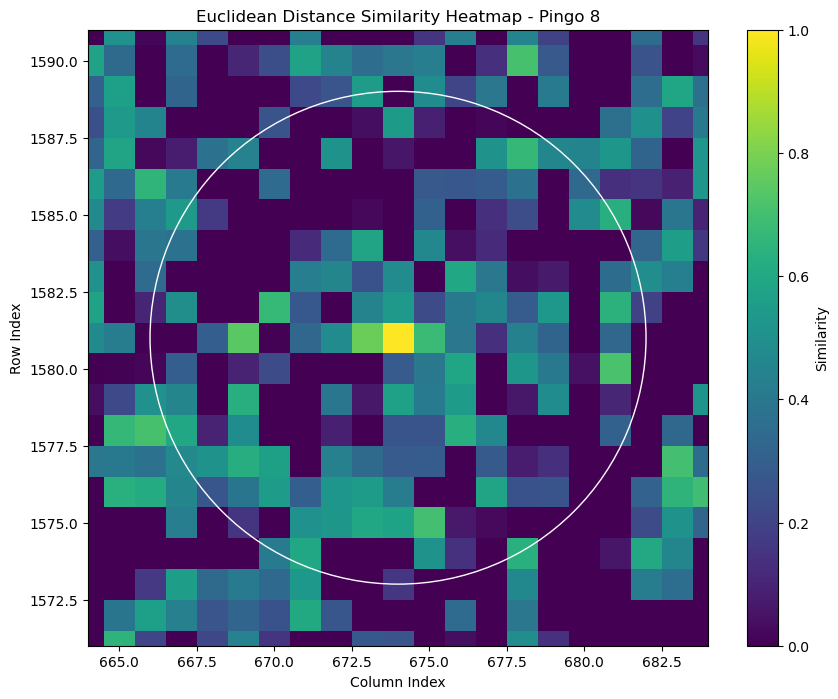

In [319]:
# Select a reference pixel for comparison
reference_pixel = series_good_tot2[1581,674,:]  # Example reference pixel

distance_threshold = 0.2

# Apply the compare_with_euclidean function
result_array = compare_with_euclidean(reference_pixel, data_array, distance_threshold)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
c = plt.Circle((674,1581),8,fill=0,color='white')
plt.gca().add_artist(c)
plt.xlim(664,684)
plt.ylim(1571,1591)
plt.imshow(result_array, cmap='viridis', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='Similarity')
plt.title('Euclidean Distance Similarity Heatmap - Pingo 8')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

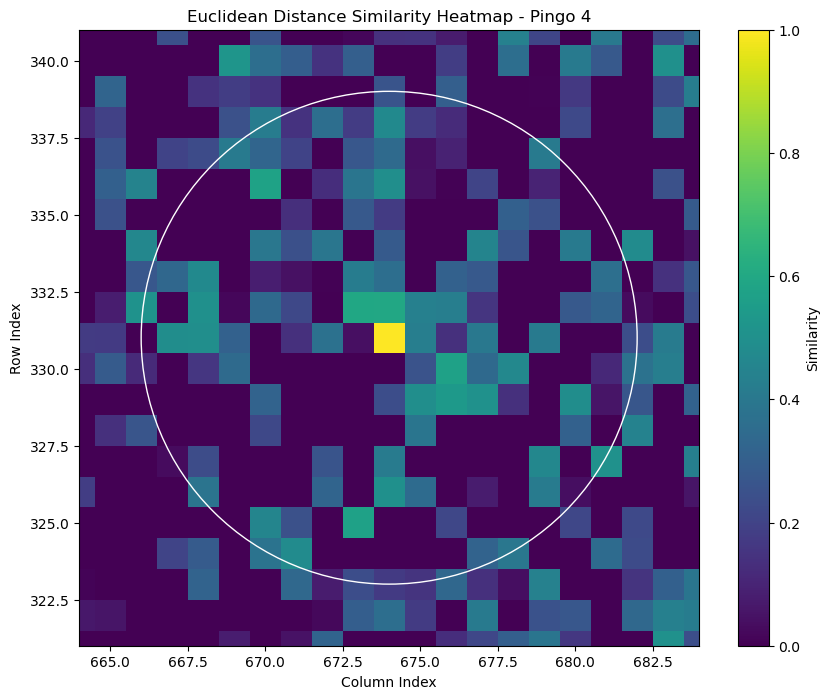

In [317]:
# Select a reference pixel for comparison
reference_pixel = series_good_tot2[331,674,:]  # Example reference pixel

distance_threshold = 0.2

# Apply the compare_with_euclidean function
result_array = compare_with_euclidean(reference_pixel, data_array, distance_threshold)


# Plotting the heatmap
plt.figure(figsize=(10, 8))
c = plt.Circle((674,331),8,fill=0,color='white')
plt.gca().add_artist(c)
plt.xlim(664,684)
plt.ylim(321,341)
plt.imshow(result_array, cmap='viridis', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='Similarity')
plt.title('Euclidean Distance Similarity Heatmap - Pingo 4')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

In [ ]:
# euclidean approach scaled with distance/ gaussian model

In [385]:
def gaussian_model(distance, sigma):
    return np.exp(-0.5 * (distance / sigma)**2)

def calculate_similarity(dataset, target_pixel, scaling_sigma, y_radius_sigma):
    num_pixels_x, num_pixels_y, num_scenes = dataset.shape
    target_time_series = dataset[target_pixel[0], target_pixel[1], :]
    
    similarities = np.zeros((num_pixels_x, num_pixels_y))
    
    for x in range(num_pixels_x):
        for y in range(num_pixels_y):
            if (x, y) != target_pixel:
                other_time_series = dataset[x, y, :]
                euclidean_dist = euclidean(target_time_series, other_time_series)
                
                radial_distance = np.sqrt((x - target_pixel[0])**2 + (y - target_pixel[1])**2)
                y_dependency = gaussian_model(radial_distance, y_radius_sigma)
                
                similarity = np.exp(-scaling_sigma * euclidean_dist) * y_dependency
                similarities[x, y] = similarity
    
    return similarities


In [446]:
results_7 = calculate_similarity(series_good_tot2, (770,790), 2, 10)

In [447]:
def visualize_similarity(similarity_matrix):
    plt.figure(figsize=(10, 8))
    c = plt.Circle((790,770),8,fill=0,color='white')
     
    c2 = plt.Circle((1161,152), 12, fill = 0, color =  'darkorange')
    c3 = plt.Circle((792,310), 12, fill = 0, color = 'red')
    c4 = plt.Circle((830,323), 12, fill = 0, color = 'ghostwhite')
    c5 = plt.Circle((674,331), 12, fill = 0, color = 'darkorange')
    c6 = plt.Circle((413,694), 12, fill = 0, color = 'darkorange')
    c7 = plt.Circle((831,727), 12, fill = 0, color = 'black')
    c8 = plt.Circle((790,770), 12, fill = 0, color = 'ghostwhite')
    c9 = plt.Circle((674,1581), 12, fill = 0, color = 'black')
    c10 = plt.Circle((627,1783), 12, fill = 0, color = 'darkorange')
    c11 = plt.Circle((718,1821), 12, fill = 0, color = 'ghostwhite')
    c12 = plt.Circle((659,1962), 12, fill = 0, color = 'black')
    c13 = plt.Circle((571,2019), 12, fill = 0, color = 'black')
    plt.gca().add_artist(c2)
    plt.gca().add_artist(c3)
    plt.gca().add_artist(c4)
    plt.gca().add_artist(c5)
    plt.gca().add_artist(c6)
    plt.gca().add_artist(c7)
    plt.gca().add_artist(c8)
    plt.gca().add_artist(c9)
    plt.gca().add_artist(c10)
    plt.gca().add_artist(c11)
    plt.gca().add_artist(c12)
    plt.gca().add_artist(c13)

    #plt.xlim(780,800)
    #plt.ylim(760,780)
    plt.imshow(similarity_matrix, cmap='viridis', origin='upper')
    plt.colorbar(label='Similarity')
    plt.title('Similarity Heatmap')
    plt.xlabel('Pixel Y Coordinate')
    plt.ylabel('Pixel X Coordinate')

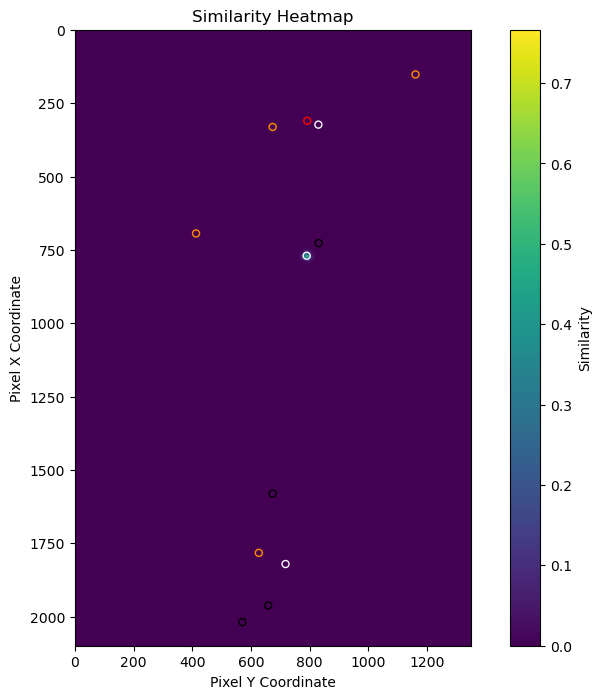

In [448]:
visualize_similarity(results_7)

(740.0, 800.0)

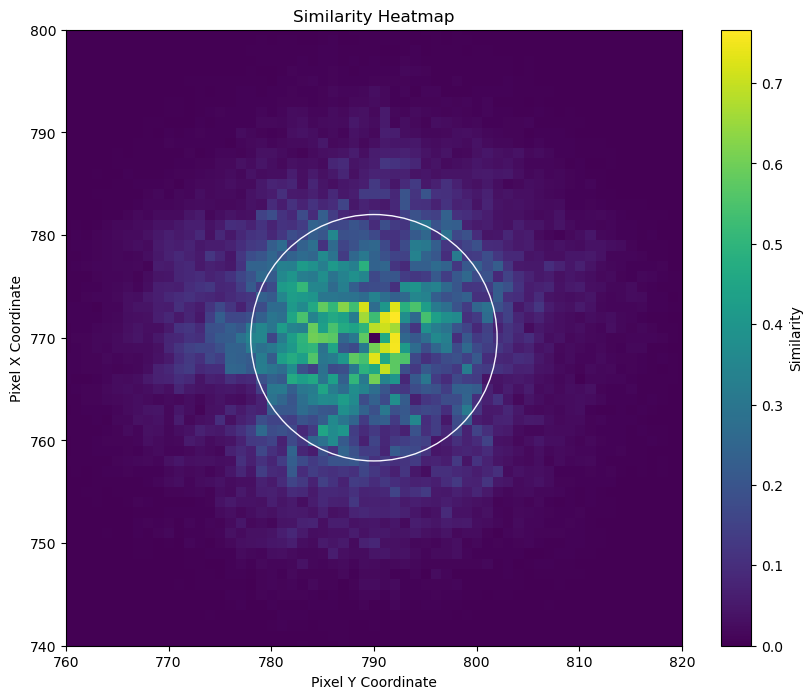

In [449]:
visualize_similarity(results_7)
plt.xlim(760,820)
plt.ylim(740,800)

In [450]:
results_2 = calculate_similarity(series_good_tot2, (310,792), 2, 10)

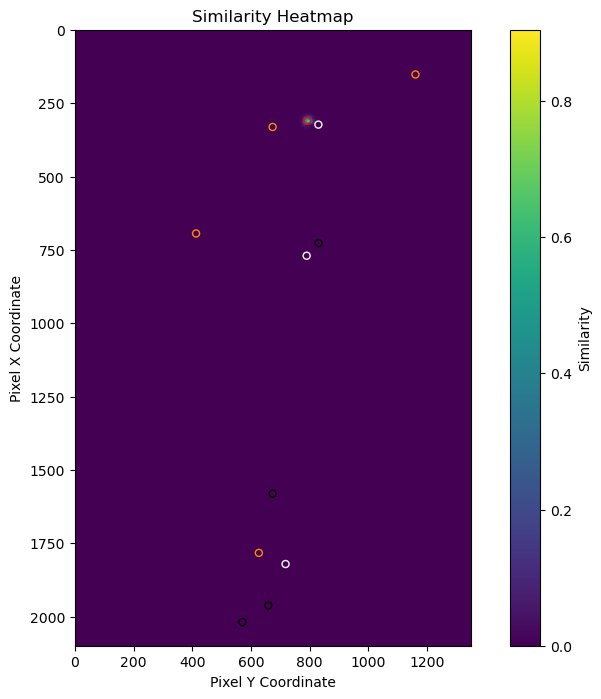

In [451]:
visualize_similarity(results_2)

(290.0, 330.0)

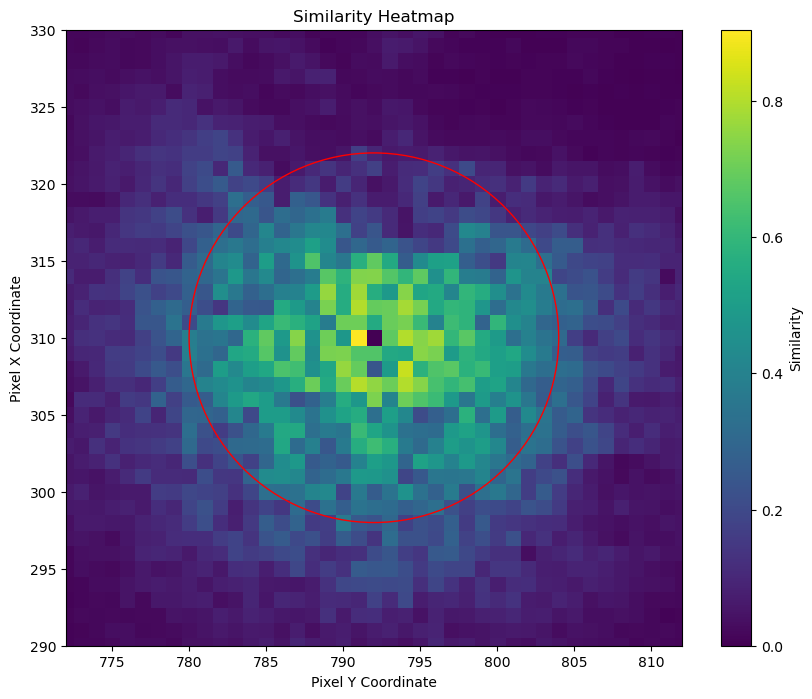

In [452]:
visualize_similarity(results_2)
plt.xlim(772,812)
plt.ylim(290,330)

In [453]:
results_3 = calculate_similarity(series_good_tot2, (323,830), 2, 10)

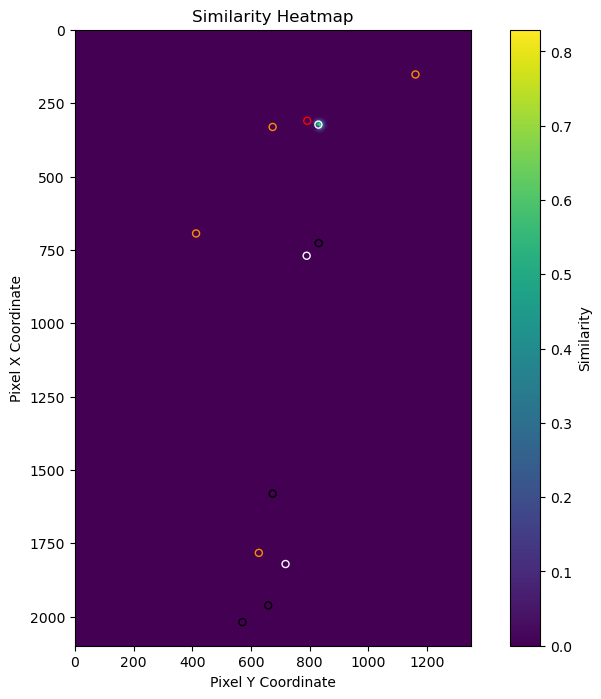

In [454]:
visualize_similarity(results_3)

(300.0, 340.0)

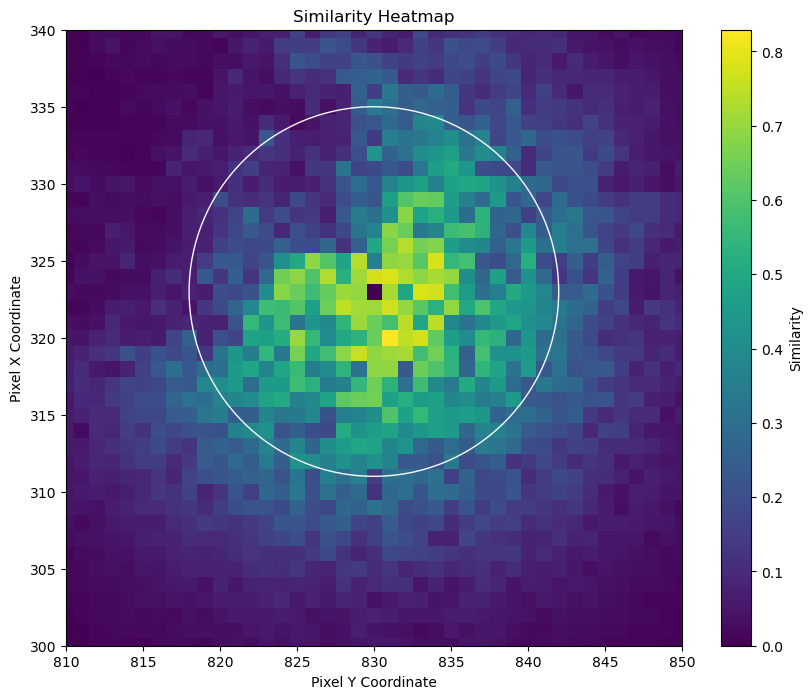

In [455]:
visualize_similarity(results_3)
plt.xlim(810,850)
plt.ylim(300,340)

In [456]:
results_4 = calculate_similarity(series_good_tot2, (331,674), 2, 10)

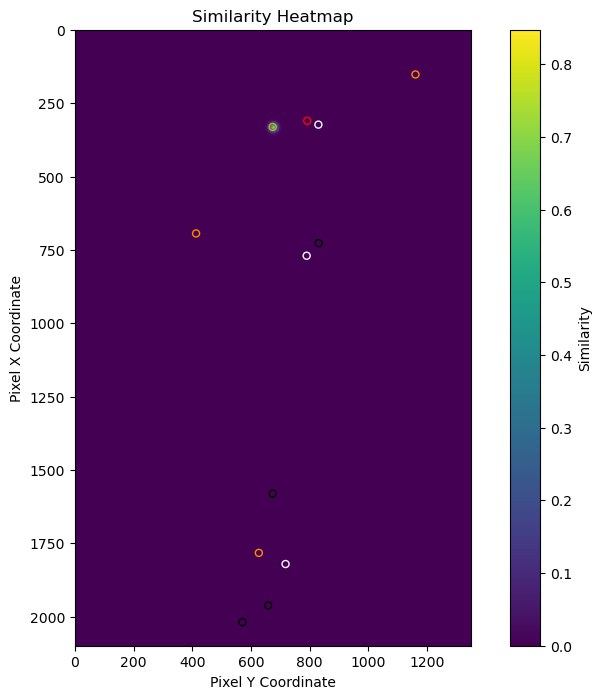

In [457]:
visualize_similarity(results_4)

(311.0, 351.0)

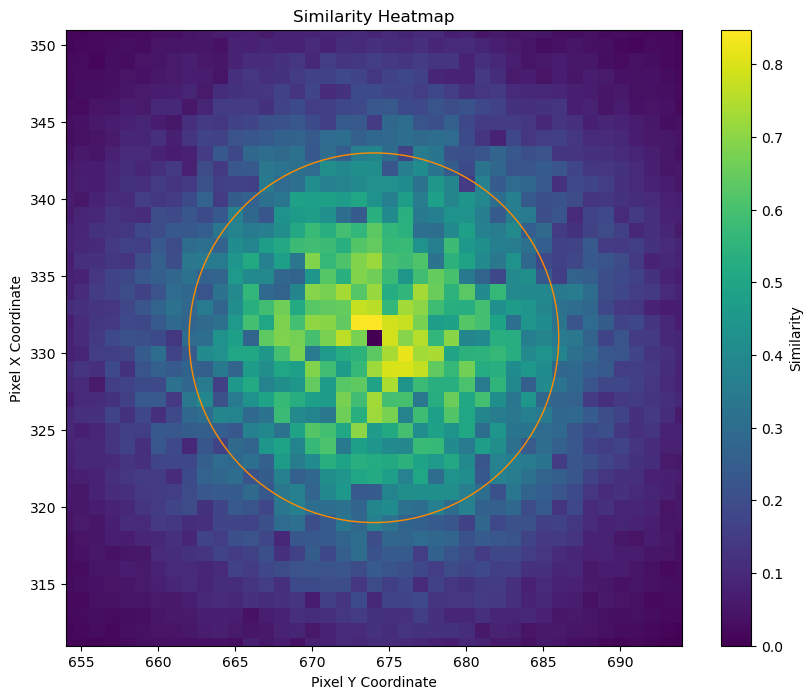

In [458]:
visualize_similarity(results_4)
plt.xlim(654,694)
plt.ylim(311,351)

In [459]:
results_8 = calculate_similarity(series_good_tot2, (1581,674), 2, 10)

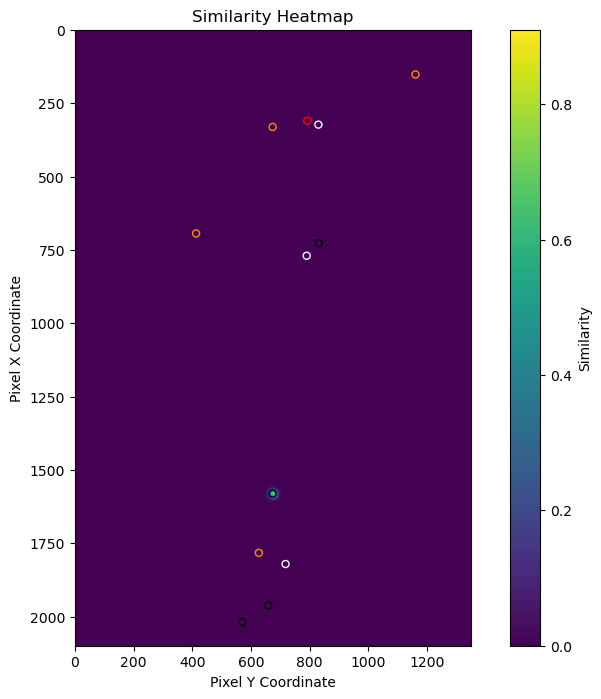

In [460]:
visualize_similarity(results_8)

(1561.0, 1601.0)

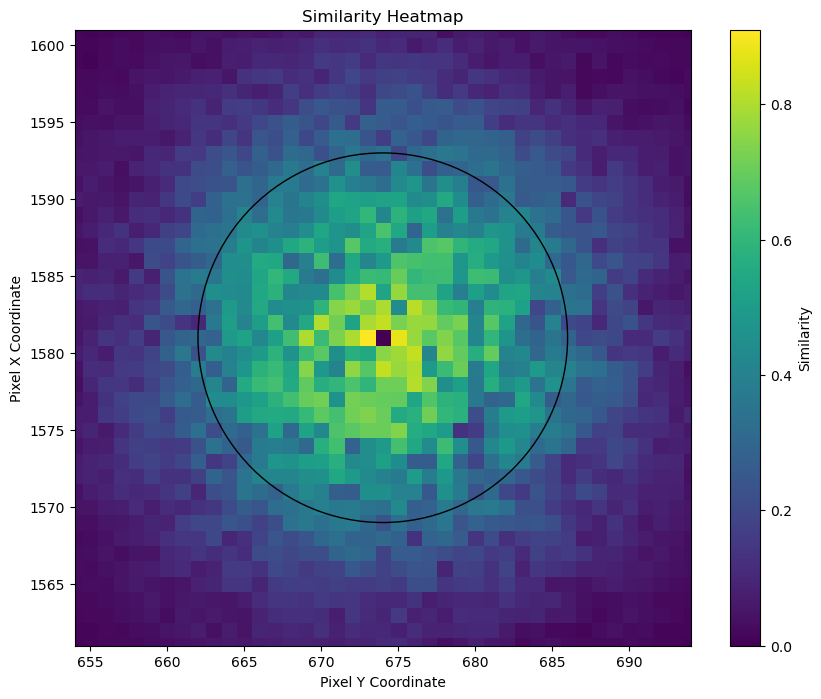

In [461]:
visualize_similarity(results_8)
plt.xlim(654,694)
plt.ylim(1561,1601)